# Classification of CIFAR-10 datasets

Here are the steps: 

1. Use torchvision to load and preprocess CIFAR-10 datasets;
2. define network；
3. define loss fuction and optimizer；
4. train the NN and update parameters；
5. test the NN

**CIFAR-10**

CIFAR-10 is a frequently used graph datasets，it has 10 classifications: 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'。Each graph is $3\times32\times32$，with resolution $32\times32$。

In [29]:
import torch as t
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from torch import optim
show = ToPILImage() # transfer Tensor to Image for visualization

## Preprocessing

In [19]:
# preprocessing
transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]) # Normalization

# train datasets
trainset = tv.datasets.CIFAR10(
    root = './pytorch-book-cifar10/',
    train=True,
    download=True,
    transform=transform
)

trainloader = t.utils.data.DataLoader(
    trainset,
    batch_size=4,
    shuffle=True,
    num_workers=2
)

# test datasets
testset = tv.datasets.CIFAR10(
    root = './pytorch-book-cifar10/',
    train=False,
    download=True,
    transform=transform
)

testloader = t.utils.data.DataLoader(
    testset,
    batch_size=4,
    shuffle=False,
    num_workers=2
)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


ship


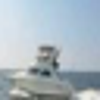

In [20]:
(data, label) = trainset[100]
print(classes[label])

# (data + 1) / 2 to get data before normalization
show((data + 1) / 2).resize((100, 100))

**Dataloarder is a iterable object, it combine each data sample returned from datasets into one batch, providing multithreading accelerating optimization and data shuffle. When the programming iterates all the data, it iterates the Dataloader, too.**

      ship        cat        dog       frog


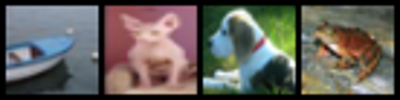

In [27]:
dataiter = iter(trainloader)

images, labels = next(dataiter)

print(' '.join('%10s'%classes[labels[j]] for j in range(4)))
          
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

## Define the NN

In [28]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # CIFAR-10 is 3-channel image datasets
        self.conv2 = nn.Conv2d(6, 16, 5)  
        self.fc1   = nn.Linear(16*5*5, 120)  
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) 
        x = F.max_pool2d(F.relu(self.conv2(x)), 2) 
        x = x.view(x.size()[0], -1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)        
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Defien Loss Function and Optimizer

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Train the NN

In [33]:
for epoch in range(3):
    
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        
        # input the data
        inputs, labels = data
        
        # empty grad
        optimizer.zero_grad()
        
        # forward + backward 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()   
        
        # update parameters
        optimizer.step()
        
        # print log
        # loss is a scalar, use loss.item() not loss[0]
        running_loss += loss.item()
        if i % 2000 == 1999: # print training status for every 2000 batches
            print('[%d, %5d] loss: %.2f' % (epoch+1, i+1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.20
[1,  4000] loss: 1.89
[1,  6000] loss: 1.70
[1,  8000] loss: 1.57
[1, 10000] loss: 1.53
[1, 12000] loss: 1.49
[2,  2000] loss: 1.40
[2,  4000] loss: 1.39
[2,  6000] loss: 1.35
[2,  8000] loss: 1.34
[2, 10000] loss: 1.28
[2, 12000] loss: 1.29
[3,  2000] loss: 1.23
[3,  4000] loss: 1.23
[3,  6000] loss: 1.21
[3,  8000] loss: 1.20
[3, 10000] loss: 1.18
[3, 12000] loss: 1.20
Finished Training


## Test

Actual label: 
       cat       ship       ship      plane


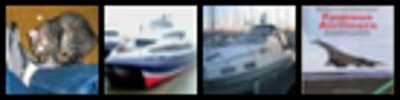

In [40]:
# Actual - Sample
dataiter = iter(testloader)
images,labels = next(dataiter)
print('Actual label: ')
print(' '.join('%10s'%classes[labels[j]] for j in range(4)))
show(tv.utils.make_grid((images+1)/2)).resize((400,100))

In [42]:
# Predict - Sample
outputs=net(images) # calculate the score for each class
_, predicted = t.max(outputs.data, 1) # choose the class got the highest score

print('Predict label: ')
print(' '.join('%10s'%classes[predicted[j]] for j in range(4)))

# It is pretty accurate

Predict label: 
       cat        car        car       ship


In [46]:
correct = 0 
total = 0

with t.no_grad(): # shut down autograd to speed up and save memory
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = t.max(outputs,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum()
print('Accuracy: %.2d%%' % (100*correct//total))

Accuracy: 56%


## Try to train on GPU

In [47]:
device = t.device("cuda:0" if t.cuda.is_available() else "cpu")

net.to(device)
images = images.to(device)
labels = labels.to(device)
output = net(images)
loss= criterion(output,labels)

loss

tensor(0.3451, grad_fn=<NllLossBackward0>)